## Transfer Learning on CNNs

### Imports

In [ ]:
# Core
import numpy as np
import pandas as pd
import os
# from tqdm.auto import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Torch
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from torchvision.models import vgg11, vgg11_bn, resnet18, resnet34, densenet121, mobilenet_v3_small

In [3]:
# Set the random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

# Set default device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if(torch.cuda.is_available()):
    print('Using GPU: ' + torch.cuda.get_device_name(device))
else:
    print('Using CPU')

Using CPU


### 1.1 Compare pretrained models

Compare pretrained models: VGG11, VGG11 with batch normalization, ResNet18,
ResNet34, DenseNet121 and MobileNet-v3-Small for Top-1 accuracy & inference speed on imgNet.



In [4]:
DATASET = 'IMAGENET1K_V1'
INPUT_SIZE = 1, 3, 256, 256
N_IMGS = 10
TEST_IMG = torch.rand(INPUT_SIZE, dtype=torch.float)

models = {
    'VGG11': vgg11(weights=DATASET),
    'VGG11_BN':vgg11_bn(weights=DATASET),
    'ResNet18': resnet18(weights=DATASET),
    'ResNet34': resnet34(weights=DATASET),
    'DenseNet121': densenet121(weights=DATASET),
    'MobileNetV3_Small': mobilenet_v3_small(weights=DATASET)
}

models_info = {
    'VGG11': {'n_params': 132863336, 'top1acc': 0.690},
    'VGG11_BN': {'n_params': 132863336, 'top1acc': 0.704},
    'ResNet18': {'n_params' : 11689512, 'top1acc': 0.698},
    'ResNet34': {'n_params': 21797672, 'top1acc': 0.733},
    'DenseNet121': {'n_params': 7978856, 'top1acc': 0.7443},
    'MobileNetV3_Small': {'n_params': 2542856, 'top1acc': 0.677}
}

df_models = pd.DataFrame(index=models.keys(), columns=['n_params', 'top1acc', 'infer_time_nograd', 'infer_time_grad', 'gpu_usage_nograd', 'gpu_usage_grad'])
df_models.loc[:, 'n_params'] = [model['n_params'] for model in models_info.values()]
df_models.loc[:, 'top1acc'] = [model['top1acc'] for model in models_info.values()]


Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /Users/neil/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /Users/neil/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/neil/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/neil/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/neil/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/neil/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

/var/folders/mh/trbb8msj5jj47dl4zblft0z00000gn/T/ipykernel_56299/1437197603.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_models.loc[:, 'n_params'] = [model['n_params'] for model in models_info.values()]
/var/folders/mh/trbb8msj5jj47dl4zblft0z00000gn/T/ipykernel_56299/1437197603.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_models.loc[:, 'top1acc'] = [model['top1acc'] for model in models_info.values()]


In [ ]:
def get_infer_time(model, n_iter, no_grad=True):
    model.to(device)
    img = img.to(device)
    times = []
    start, end = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

    model.eval()
    # warmup
    X = torch.rand(INPUT_SIZE, dtype=torch.float, device=device)
    for i in range(10):
        _ = model(X)
    
    for i in range(n_iter):
        X = torch.rand(INPUT_SIZE, dtype=torch.float, device=device)
        start.record()
        if no_grad:
            with torch.no_grad():
                _ = model(X)
        else:
            _ = model(X)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    # model.cpu()
    # img = img.cpu().detach()
    return np.mean(times)

n_iter = 100
df_models.loc[:, 'infer_time_nograd'] = [get_infer_time(model, n_iter) for model in models.values()]
df_models.loc[:, 'infer_time_grad'] = [get_infer_time(model, n_iter, no_grad=False) for model in models.values()]

#### a. Compare inference times, #params & accuracy for different models

Text(0.5, 0.98, 'Comparison of inference time, accuracy and # parameters for different models')

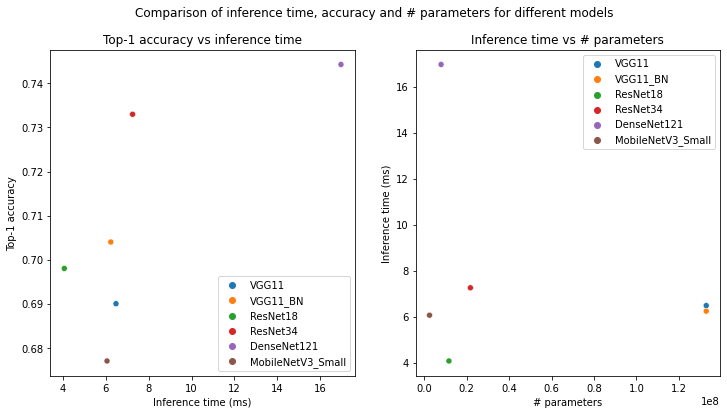

In [ ]:
# Compare models (inference time vs accuracy, inference time vs params)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=df_models, x='infer_time_nograd', y='top1acc', hue=df_models.index, ax=axs[0])
axs[0].set_xlabel('Inference time (ms)')
axs[0].set_ylabel('Top-1 accuracy')
axs[0].set_title('Top-1 accuracy vs inference time')
sns.scatterplot(data=df_models, x='n_params', y='infer_time_nograd', hue=df_models.index, ax=axs[1])
axs[1].set_xlabel('# parameters')
axs[1].set_ylabel('Inference time (ms)')
axs[1].set_title('Inference time vs # parameters')
fig.suptitle('Comparison of inference time, accuracy and # parameters for different models')

#### b. Compare inference times with and without torch.no_grad()

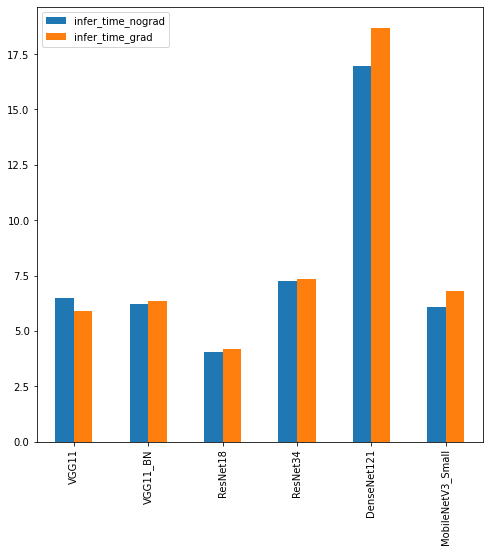

In [6]:
df_models.plot(y=['infer_time_nograd', 'infer_time_grad'], kind='bar', figsize=(8, 8), xlabel='models', ylabel='inference time (ms)', title='Inference time with and without grad')
plt.show()

#### c. Compare GPU vRAM usage with and without torch.no_grad()

In [18]:
def get_gpu_usage(model, batch_size, use_grad=True):    

    torch.cuda.empty_cache()
    mem_start = torch.cuda.memory_allocated()
    with torch.set_grad_enabled(use_grad):
      model.to(device)
      model.eval()
      X = torch.rand((batch_size, *INPUT_SIZE[1:]), dtype=torch.float, device=device)
      y = model(X)
    mem_end = torch.cuda.memory_allocated()
    mem_used = (mem_end - mem_start) / 10**6
    
    model.cpu()
    X = X.cpu().detach()
    y = y.cpu().detach()
    del X, y, model
    torch.cuda.empty_cache()
            
    return mem_used
 
BATCH_SIZE=64
df_models.loc[:, 'gpu_usage_nograd'] = [get_gpu_usage(model, BATCH_SIZE, use_grad=False) for model in models.values()]
df_models.loc[:, 'gpu_usage_grad'] = [get_gpu_usage(model, BATCH_SIZE, use_grad=True) for model in models.values()]  

In [19]:
df_models

,n_params,top1acc,infer_time_nograd,infer_time_grad,gpu_usage_nograd,gpu_usage_grad
VGG11,132863336,0.6900,6.480766,5.893593,582.434816,4609.097728
VGG11_BN,132863336,0.7040,6.238887,6.359577,582.483968,7092.174848
ResNet18,11689512,0.6980,4.071831,4.176497,97.448960,1901.130752
ResNet34,21797672,0.7330,7.253968,7.367385,138.839040,2782.168064
DenseNet121,7978856,0.7443,16.965344,18.702260,82.945536,10939.737600
MobileNetV3_Small,2542856,0.6770,6.062861,6.790700,60.869120,1377.157632


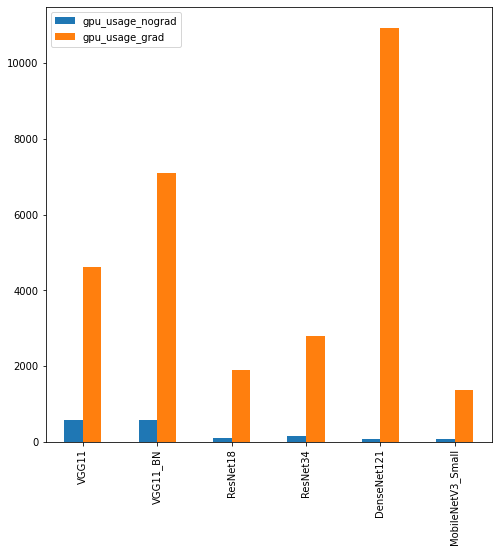

In [21]:
df_models.plot(y=['gpu_usage_nograd', 'gpu_usage_grad'], kind='bar', figsize=(8, 8))
plt.savefig(os.path.join(output_dir, 'gpu_usage_grads.png'))
plt.show()